# Lab 5:  RC Circuit Analysis

# Theory
The capacitor relationship is defined to be
$$C≝\frac{Q}{V}\tag{1}$$
Where $C$ is the capacitance of the capacitor, $Q$ is the charge contained within the capacitor, and $V$ is the voltage
across the capacitor. We can use this relationship to compute the capacitance of the capacitor, however we must be
able to measure the charge. The easiest way to do that is to remember that the charge that flows into the capacitor
per unit time is the current. So if we measure the current, $I$, flowing into the capacitor, we can integrate:
$$I(t)=\frac{dQ(t)}{dt}\; or \; Q(t)=∫^t_{0}I(t)dt\tag{2}$$


# The Discharging Capacitor
To determine the charge and current through a capacitor which is discharging, we can use Kirchhoff’s Loop Rule on
a circuit containing only the charged capacitor with capacitance, $C$, and a resistor, $R$. There are no sources of EMF,
so we may write
$$V_{C}+V_{R} = 0$$
$$\frac{Q}{C}+IR = 0$$
$$\frac{Q}{C}+R\frac{dQ}{dt} = 0$$
$$\frac{dQ}{dt} = −\frac{Q}{RC}$$
$$\frac{dQ}{Q}= −\frac{dt}{RC}$$
$$lnQ = −\frac{t}{RC}+K$$

If we then exponentiate both sides and set the initial charge to be $Q_{0}$
at time t=0 we find
$$Q(t)=Q_{0}e^{−\frac{t}{RC}}\tag{3}$$
We define the time constant,
$$τ≝RC\tag{4}$$
A derivative of the charge gives us the current:
$$I(t)=\frac{dQ}{dt} = \frac{Q_{0}}{RC}e^{−\frac{t}{τ}}=I_{0}e^{−\frac{t}{τ}}\tag{5}$$


# The Charging Capacitor
To determine the charge and current flowing into a charging capacitor, we can, once again, use Kirchhoff’s Loop
Rule, but now we include the source EMF:
$$V_{C} +V_{R} = \epsilon$$
$$\frac{Q}{C}+IR = \epsilon$$
$$\frac{Q}{RC}+\frac{dQ}{dt} =\frac{\epsilon}{R}\tag{6}$$

This type of differential equation is called an $inhomogeneous differential equation$ because the constant term is no
longer zero. The solution to this differential equation is the sum of two parts: we add together the solution to the
homogeneous equation with a particular solution, $Q_{p}$
, that does not depend on time:
$$Q(t)=Ke^{−\frac{t}{RC}} +Q_{p}\tag{7}$$
where we will have to re-evaluate the constant, $K$. When we replace this into (6) we find that $Qp=εC$ . We
now set our initial condition so that the initial charge is zero at $t=0$:
Q(0)=K+εC=0 or K=−εC
We then re-write (7):
$$Q(t)=εC(1−e^{−\frac{t}{τ}})\tag{8}$$

A derivative with respect to time gives us the current:

$$I(t)=\frac{dQ}{dt} = \frac{\epsilon}{R}e^{−\frac{t}{τ}}\tag{9}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats


import sys; sys.path.insert(0, '..')
from P202_Functions import *

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here and it should work fine.

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

# Capacitor-Resistor Combination 1

In each phase of this experiment, a different combination of capactior and resistor, in a series circuit, was used.  The theory is as follows:

When the switch is closed, thus defining $t=0$, the voltage across the capacitor will be given by:

$
\begin{equation}
V(t) = V_{source}(1 - e^{-\frac{t}{RC}})
\end{equation}
$

The current through the circuit, defined according to $i_C = C\frac{dV_C}{dt}$, is:

$
\begin{equation}
i(t) = \frac{V_{source}}{R}e^{-\frac{t}{RC}}
\end{equation}
$

The charge on the capacitor, defined by $Q = \int_0^t i(t)dt$, is given by:

$
\begin{equation}
Q(t) = C V_{source}(1-e^{-\frac{t}{RC}})
\end{equation}
$


In [2]:
# Create a Pandas DataFrame with data for part 1
# Enter saved file as .csv in " " below!#######
df1 = pd.read_csv("Experiment_5.csv")

# Enter EXACT MEASURED Resistor size and Capacitor size used for this trial below! (Capacitor in micro Farads uF, Resistor in Ohms)
df1_R = 15000
df1_C = 100

Tau_1= df1_R * df1_C * (1/1000000)
print('RC Time Constant:', Tau_1,'seconds')

#Enter Voltage applied to the circuit below. (Should be 10V)
E= 10.0



df1_iv = (df1.copy()).drop(df1.columns[3], axis=1).dropna()
df1_q = (df1.copy()).drop(df1.columns[2], axis=1)
df1_q = (df1_q.copy()).drop(df1_q.columns[1], axis=1).dropna()

RC Time Constant: 1.5 seconds


In [3]:
df1_iv = df1_iv.set_axis(['t', 'v', 'i'], axis=1, inplace=False)
df1_q = df1_q.set_axis(['t', 'q'], axis=1, inplace=False)

df1_iv['di']=0.000001
df1_iv['dv']=0.001
df1_iv['dt']=0.0001

df1_q['dt']=0.0001
df1_q['dq']=1E-8

#pd.set_option('display.max_rows', None)
df1_iv

,t,v,i,di,dv,dt
0,0.0000,0.008,-0.000123,0.000001,0.001,0.0001
2,0.0005,0.009,-0.000091,0.000001,0.001,0.0001
4,0.0010,0.007,-0.000091,0.000001,0.001,0.0001
6,0.0020,0.009,-0.000101,0.000001,0.001,0.0001
8,0.0020,0.008,-0.000079,0.000001,0.001,0.0001
...,...,...,...,...,...,...
56408,14.1020,10.193,0.002000,0.000001,0.001,0.0001
56410,14.1030,10.194,0.002000,0.000001,0.001,0.0001
56412,14.1030,10.194,0.002000,0.000001,0.001,0.0001
56414,14.1040,10.194,0.002000,0.000001,0.001,0.0001


Our first task is to define the $t=0$ point.  We should graph the raw data, for voltage vs. time, and use this plot to decide on the fit region.

<ErrorbarContainer object of 3 artists>

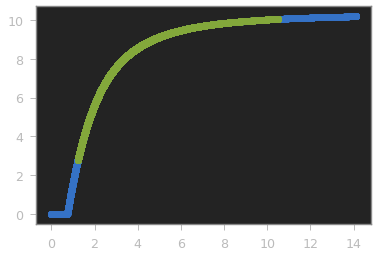

In [4]:
xi_all1 = np.array(df1_iv['t'])
yi_all1 = np.array(df1_iv['v'])
sigmaxi_all1 = np.array(df1_iv['dt'])
sigmayi_all1 = np.array(df1_iv['dv'])

plt.errorbar(xi_all1, yi_all1, xerr=sigmaxi_all1, yerr=sigmayi_all1, fmt='o', capsize=2, capthick=1)
#plt.xlim(1.2,1.23)
#plt.ylim(-0.025,0.025)
#Adjust tlow and thigh below to encompass the bend of the graph for best fit. 
tlow = 1.220
thigh = 10.500

df1_iv_select = df1_iv[(df1_iv['t']>tlow) & (df1_iv['t']<thigh)]
xi1 = np.array(df1_iv_select['t'])
yi1 = np.array(df1_iv_select['v'])
sigmaxi1 = np.array(df1_iv_select['dt'])
sigmayi1 = np.array(df1_iv_select['dv'])


plt.errorbar(xi1, yi1, xerr=sigmaxi1, yerr=sigmayi1, fmt='o', capsize=2, capthick=1)



[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12.  13.5]
[0.         6.32120559 8.64664717 9.50212932 9.81684361 9.93262053
 9.97521248 9.99088118 9.99664537 9.9987659 ]


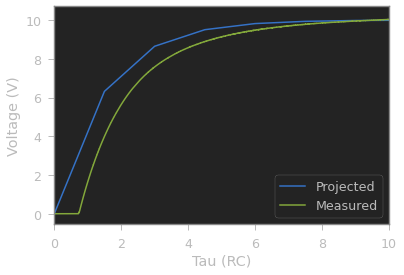

In [5]:

exp1_Tau = Tau_1 * np.arange(0,10)
print(exp1_Tau)
Exp_E = E * (1 - np.exp(-np.arange(0,10)))
print(Exp_E)

fig = plt.figure()
plt.plot(exp1_Tau,Exp_E,label='Projected')
plt.plot(xi_all1, yi_all1, label='Measured')
plt.xlabel('Tau (RC)')
plt.ylabel('Voltage (V)')
plt.xlim(0,10)
plt.legend()
plt.show()

Beta: [9.97997692 0.5998958  1.71728429]
Beta Std Error: [0.00089767 0.00094031 0.00117724]
Beta Covariance: [[ 1.80718449e-10 -9.11149107e-11  1.71842424e-10]
 [-9.11149107e-11  1.98297324e-10 -2.16282618e-10]
 [ 1.71842424e-10 -2.16282618e-10  3.10813913e-10]]
Residual Variance: 4458.919447941498
Inverse Condition #: 0.145614868452997
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (9.979976916 +/- 0.000897669) (1 - EXP(-(X - (0.599895798 +/- 0.000940315))/(1.717284289 +/- 0.001177240)))
1.5


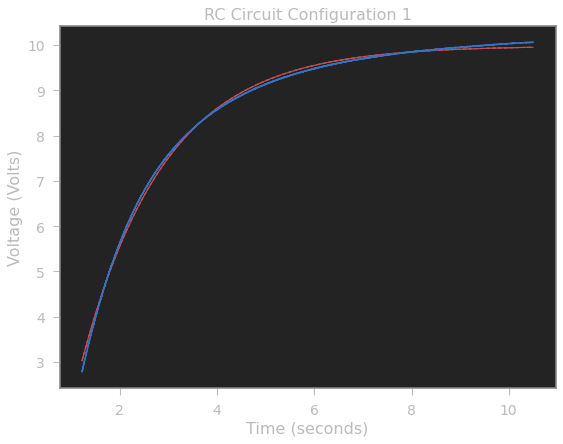

In [6]:
popt, pcov, perr = charging_fit_plot(xi1,yi1,sigmaxi1,sigmayi1,plt,tlow,thigh)

#########################
print(Tau_1)

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (Volts)')
plt.title('RC Circuit Configuration 1')
plt.show()

In [7]:
# Create a Pandas DataFrame with data for part 2
# Enter saved file as .csv in " " below!#########
df2 = pd.read_csv("Exp_5_220.csv")

# Enter EXACT MEASURED Resistor size and Capacitor size user for this trial below! (Capacitor in micro Farads uF, Resistor in Ohms)
df2_R = 220
df2_C = 1000
Tau_2 = df2_R * df2_C * (1/1000000)
print('RC Time Constant:', Tau_2,'seconds')

#Enter Voltage applied to the circuit below. (Should be 10V)
E= 10.0

df2_iv = (df2.copy()).drop(df2.columns[3], axis=1).dropna()
df2_q = (df2.copy()).drop(df2.columns[2], axis=1)
df2_q = (df2_q.copy()).drop(df2_q.columns[1], axis=1).dropna()

RC Time Constant: 0.22 seconds


In [8]:
df2_iv = df2_iv.set_axis(['t', 'v', 'i'], axis=1, inplace=False)
df2_q = df2_q.set_axis(['t', 'q'], axis=1, inplace=False)

df2_iv['di']=0.000001
df2_iv['dv']=0.001
df2_iv['dt']=0.0001

df2_q['dt']=0.0001
df2_q['dq']=1E-8

#pd.set_option('display.max_rows', None)
df2_iv

,t,v,i,di,dv,dt
0,0.0000,0.002,-0.000058,0.000001,0.001,0.0001
2,0.0005,0.002,-0.000068,0.000001,0.001,0.0001
4,0.0010,0.002,-0.000046,0.000001,0.001,0.0001
6,0.0020,0.002,-0.000050,0.000001,0.001,0.0001
8,0.0020,0.002,-0.000040,0.000001,0.001,0.0001
...,...,...,...,...,...,...
42352,10.5880,10.589,0.000086,0.000001,0.001,0.0001
42354,10.5890,10.588,0.000114,0.000001,0.001,0.0001
42356,10.5890,10.589,0.000099,0.000001,0.001,0.0001
42358,10.5900,10.589,0.000086,0.000001,0.001,0.0001


<ErrorbarContainer object of 3 artists>

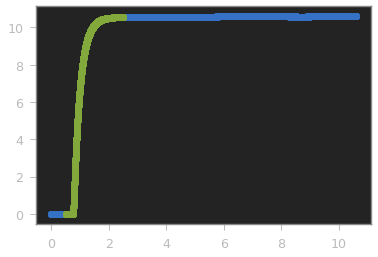

In [9]:
xi_all2 = np.array(df2_iv['t'])
yi_all2 = np.array(df2_iv['v'])
sigmaxi2 = np.array(df2_iv['dt'])
sigmayi2 = np.array(df2_iv['dv'])

plt.errorbar(xi_all2, yi_all2, xerr=sigmaxi2, yerr=sigmayi2, fmt='o', capsize=2, capthick=1)
#plt.xlim(1.2,1.23)
#plt.ylim(-0.025,0.025)
#Adjust tlow and thigh below to encompass the bend of the graph for best fit.
tlow = 0.50
thigh = 2.500

df2_iv_select = df2_iv[(df2_iv['t']>tlow) & (df2_iv['t']<thigh)]
xi2 = np.array(df2_iv_select['t'])
yi2 = np.array(df2_iv_select['v'])
sigmaxi2 = np.array(df2_iv_select['dt'])
sigmayi2 = np.array(df2_iv_select['dv'])

plt.errorbar(xi2, yi2, xerr=sigmaxi2, yerr=sigmayi2, fmt='o', capsize=2, capthick=1)

[0.   0.22 0.44 0.66 0.88 1.1  1.32 1.54 1.76 1.98]
[0.         6.32120559 8.64664717 9.50212932 9.81684361 9.93262053
 9.97521248 9.99088118 9.99664537 9.9987659 ]


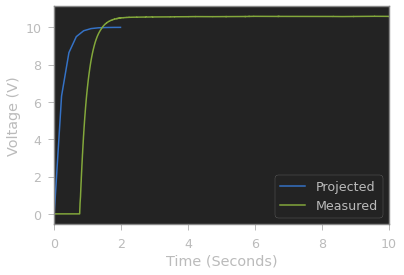

In [10]:
exp2_Tau = Tau_2 * np.arange(0,10)
print(exp2_Tau)
Exp_E2 = E * (1 - np.exp(-np.arange(0,10)))
print(Exp_E2)

fig = plt.figure()
plt.plot(exp2_Tau,Exp_E2,label="Projected")
plt.plot(xi_all2, yi_all2, label='Measured')
plt.xlabel('Time (Seconds)')
plt.ylabel('Voltage (V)')
plt.xlim(0,10)
plt.legend()
plt.show()

Beta: [10.67837023  0.66845779  0.30049021]
Beta Std Error: [0.01046746 0.00139374 0.00199032]
Beta Covariance: [[ 8.27272820e-10 -2.23963325e-11  1.07219749e-10]
 [-2.23963325e-11  1.46666827e-11 -1.19640621e-11]
 [ 1.07219749e-10 -1.19640621e-11  2.99097771e-11]]
Residual Variance: 132444.4601184634
Inverse Condition #: 0.1917386415673354
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (10.678370228 +/- 0.010467459) (1 - EXP(-(X - (0.668457792 +/- 0.001393743))/(0.300490207 +/- 0.001990323)))
0.22 seconds


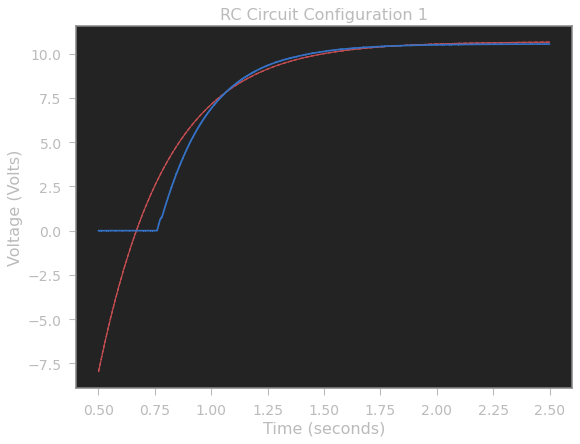

In [11]:
popt2, pcov2, perr2 = charging_fit_plot(xi2,yi2,sigmaxi2,sigmayi2,plt,tlow,thigh)

#########################
print(Tau_2,'seconds')

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (Volts)')
plt.title('RC Circuit Configuration 1')
plt.show()